In [1]:

# yeni hali 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import os

import tensorflow as tf

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,  LSTM , BatchNormalization


In [2]:
import yfinance as yf

In [3]:
period = '3000d'

#tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL', 'TSLA', 'NVDA', 'PYPL', 'ADBE','BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD','BCH-USD', 'BNB-USD', 'LINK-USD', 'ADA-USD', 'XLM-USD', 'SOL-USD', 'TRX-USD']

tickers = ['SOL-USD']


In [4]:
def indir_ve_df_olustur(tickers, period):
    # Her bir hisse senedi için boş bir sözlük oluşturun
    pariteler = {}

    # Her bir hisse senedi için döngü oluşturun ve verileri indirin
    for ticker in tickers:
        try:
            # Hisse senedi verilerini indirin
            veri = yf.download(ticker, period=period)
            
            # Veriyi sözlüğe ekleyin
            pariteler[ticker] = veri
        except Exception as e:
            print(f"{ticker} için veri indirilirken bir hata oluştu: {str(e)}")

    # Her bir hisse senedi için ayrı bir veri çerçevesi oluşturun
    df_listesi = [veri for veri in pariteler.values()]

    return df_listesi

In [5]:
#pariteler adında klasör oluştur :

import os 

if not os.path.exists('datas/pariteler'):
    os.makedirs('datas/pariteler')



In [6]:
datasets = indir_ve_df_olustur(tickers, period)

#pariteler içine kaydet 

for i in range(len(datasets)):
    datasets[i].to_csv(f'datas/pariteler/{tickers[i]}.csv')
    #print(f'{tickers[i]} verisi csv olarak kaydedildi')


[*********************100%***********************]  1 of 1 completed


In [7]:
window = 30

def veri_hazirla(df, window):
    # Veri çerçevesinin kopyasını oluşturun
    df = df.copy()
    
    # Veri çerçevesine yeni sütunlar ekleyin
    for i in range(1, window + 1):
        df[f'Önceki_{i}_Açılış'] = df['Open'].shift(i)
        df[f'Önceki_{i}_Yüksek'] = df['High'].shift(i)
        df[f'Önceki_{i}_Düşük'] = df['Low'].shift(i)
        df[f'Önceki_{i}_Kapanış'] = df['Close'].shift(i)
        df[f'Önceki_{i}_Adj'] = df['Adj Close'].shift(i)
        df[f'Önceki_{i}_Hacim'] = df['Volume'].shift(i)
        
    # NaN değerleri bırakın
    df.dropna(inplace=True)
    
    return df

# Her bir veri çerçevesi için döngü oluşturun ve verileri hazırlayın
data_windowed = [veri_hazirla(df, window) for df in datasets]


if not os.path.exists('datas/windowed'):
    os.makedirs('datas/windowed')

# Her bir veri çerçevesi için parite ismiyle birlikte windowed klasörüne kaydedin 
for i in range(len(data_windowed)):
    data_windowed[i].to_csv(f'datas/windowed/{tickers[i]}_windowed.csv')
    print(f'{tickers[i]} verisi windowed olarak kaydedildi')



SOL-USD verisi windowed olarak kaydedildi


In [8]:
#data_windowed

In [9]:
#her bir veri çerçevesi için X  = features(öncekiler) y = labels olan veriyapısını kuruyoruz (labels  = ['Open','High', 'Low', 'Close', 'Adj Close', 'Volume'])

def X_y_olustur(df, window, labels):
    # Veri çerçevesinin kopyasını oluşturun
    df = df.copy()
    
    # Özellikler ve etiketler için boş listeler oluşturun
    X = []
    y = []
    
    # Her bir satır için döngü oluşturun
    for i in range(len(df) - window):
        # Özellikler için satırı alın
        X_row = df.iloc[i:i + window].values
        
        # Etiketler için satırı alın
        y_row = df[labels].iloc[i + window].values
        
        # Özellikleri ve etiketleri listelere ekleyin
        X.append(X_row)
        y.append(y_row)
        
    # Listeleri numpy dizilerine dönüştürün
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Her bir veri çerçevesi için döngü oluşturun ve X ve y oluşturun
X_y = [X_y_olustur(df, window, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']) for df in data_windowed]
#X_y = [X_y_olustur(df, window, ['Close' ,'Volume']) for df in data_windowed]

# Her bir veri çerçevesi için parite ismiyle birlikte numpy klasörüne kaydedin

if not os.path.exists('datas/numpy'):
    os.makedirs('datas/numpy')
for i in range(len(X_y)):
    np.save(f'datas/numpy/{tickers[i]}_X.npy', X_y[i][0])
    np.save(f'datas/numpy/{tickers[i]}_y.npy', X_y[i][1])
    print(f'{tickers[i]} verisi X ve y olarak kaydedildi')
    



SOL-USD verisi X ve y olarak kaydedildi


In [10]:
# her bir veri çerçevesi için train test split yapalım time series için doğru yolla yapmak gerekiyor

def train_test_split(X, y, test_size):
        # Test boyutunu hesaplayın

        
        #test_size = int(len(X) * test_size) #yüzdelikli tercih değil

        
        # Eğitim ve test veri kümelerini ayırın
        X_train = X[:-test_size]
        X_test = X[-test_size:]
        y_train = y[:-test_size]
        y_test = y[-test_size:]
        
        return X_train, X_test, y_train, y_test

# Her bir veri çerçevesi için döngü oluşturun ve train ve test veri kümelerini ayırın
test_size = 60
X_train_test = [train_test_split(X_y[i][0], X_y[i][1], 60) for i in range(len(X_y))]

In [11]:
# her bir veri çerçevesi için model oluşturup eğitelim

def model_olustur(input_shape, output_shape):
    # Modeli oluşturun
    model = Sequential()
    
    # Giriş katmanı
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    # Gizli katmanlar
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

     # Gizli katmanlar
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

     # Gizli katmanlar
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

     # Gizli katmanlar
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

     # Gizli katmanlar
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    # Çıkış katmanı
    model.add(Dense(output_shape))
    
    return model

In [12]:
tf.test.gpu_device_name()


'/device:DML:0'

In [13]:
# her bir veri çerçevesi için modeli eğitelim


if not os.path.exists('datas/models'):
    os.makedirs('datas/models')

epochs = 100
batch_size = 200
models = []

for i in range(len(X_train_test)):
    # Modeli oluşturun
    model = model_olustur(X_train_test[i][0].shape[1:], X_train_test[i][2].shape[1])
    
    # Modeli derleyin
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Modeli eğitin
    model.fit(X_train_test[i][0], X_train_test[i][2], epochs=epochs, batch_size=batch_size,
              validation_data=(X_train_test[i][1], X_train_test[i][3]),
                verbose=1)
    
    # Modeli kaydedin
    model.save(f'datas/models/{tickers[i]}_model.h5')
    
    # Modeli listeye ekleyin
    models.append(model)
    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1274 samples, validate on 60 samples
Epoch 1/100
1274/1274 [==============================] - 5s 4ms/sample - loss: 493826307182324224.0000 - val_loss: 1778972292907270144.0000
Epoch 2/100
1274/1274 [==============================] - 1s 1ms/sample - loss: 493826312468437824.0000 - val_loss: 1778972292907270144.0000
Epoch 3/100
1274/1274 [==============================] - 1s 1ms/sample - loss: 493826314302395648.0000 - val_loss: 1778972292907270144.0000
Epoch 4/100
1274/1274 [==============================] - 1s 1ms/sample - loss: 493826322717025408.0000 - val_loss: 1778972292907270144.0000
Epoch 5/100
1274/1274 [==============================] - 1s 1ms/sample - loss: 493826318240010880.0000 - val_loss: 1778972292907270144.0000
Epoch 6/100
1274/1274 [==============================] - 1s 1ms/sample - loss: 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


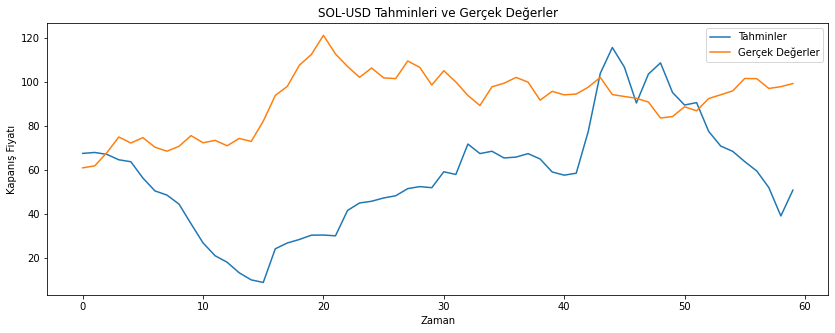

In [14]:
# Her bir model için döngü oluşturun ve tahmin yapın
for i in range(len(models)):
    # Modeli yükleyin
    model = tf.keras.models.load_model(f'datas/models/{tickers[i]}_model.h5')
    
    # Tahmin yapın
    predictions = model.predict(X_train_test[i][1])
    
    # Tahminleri ve gerçek değerleri görselleştirin sadece close
    plt.figure(figsize=(14, 5))
    plt.plot(predictions[:, 3], label='Tahminler')
    plt.plot(X_train_test[i][3][:, 3], label='Gerçek Değerler')
    plt.title(f'{tickers[i]} Tahminleri ve Gerçek Değerler')
    plt.xlabel('Zaman')
    plt.ylabel('Kapanış Fiyatı')
    plt.legend()
    plt.show()
    

    
    

In [15]:
#TODO :  normalizasyon yapılacak : zerobase - minmax scaler

#TODO : seq2seq LSTM Yapılcak denenecek

#TODO : Dikkat Mekanizması ile LSTM yapılacak